# EM+GMM

## 1.生成数据

In [1]:
# 这个函数用来绘制正态置信椭圆
def make_ellipses(mean, cov, ax, confidence=1, alpha=0.3, color="red", eigv=True, arrow_color_list=None):
    """
    多元正态分布
    mean: 均值
    cov: 协方差矩阵
    ax: 画布的Axes对象
    confidence: 置信椭圆置信率 # 置信区间， 95%： 5.991  99%： 9.21  90%： 4.605 
    alpha: 椭圆透明度
    eigv: 是否画特征向量
    arrow_color_list: 箭头颜色列表
    """
    import matplotlib as mpl
    lambda_, v = np.linalg.eig(cov)    # 计算特征值lambda_和特征向量v
    sqrt_lambda = np.sqrt(np.abs(lambda_))    # 存在负的特征值， 无法开方，取绝对值
    s = confidence
    width = 2 * np.sqrt(s) * sqrt_lambda[0]    # 计算椭圆的两倍长轴
    height = 2 * np.sqrt(s) * sqrt_lambda[1]   # 计算椭圆的两倍短轴
    angle = np.rad2deg(np.arccos(v[0, 0]))    # 计算椭圆的旋转角度
    ell = mpl.patches.Ellipse(xy=mean, width=width, height=height, angle=angle, color=color)    # 绘制椭圆
    ax.add_artist(ell)
    ell.set_alpha(alpha)

(200, 2)


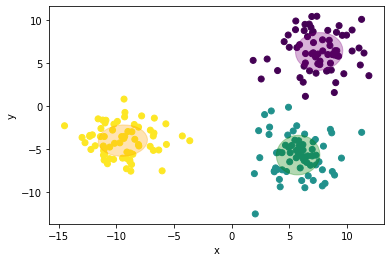

In [2]:
from sklearn.datasets import make_blobs
from matplotlib import pyplot
import numpy as np
num_of_data=200#样本总数
dimention=2 #特征维度
classes=3   #样本类别
data, label_GT = make_blobs(n_samples=num_of_data, n_features=dimention, centers=classes,cluster_std=[2,2,2])
print(data.shape)
label_None=[0]*num_of_data
# pyplot.rcParams["figure.figsize"] = (8.0, 8.0)
fig, ax = pyplot.subplots()
ax.set_xlabel("x")
ax.set_ylabel("y")
# pyplot.scatter(data[:, 0], data[:, 1], c=label_None)
pyplot.scatter(data[:, 0], data[:, 1], c=label_GT)
data_0=data[np.where(label_GT==0)]
data_1=data[np.where(label_GT==1)]
data_2=data[np.where(label_GT==2)]
make_ellipses(np.mean(data_0,axis=0),np.cov(data_0.T),ax,color="purple")
make_ellipses(np.mean(data_1,axis=0),np.cov(data_1.T),ax,color="green")
make_ellipses(np.mean(data_2,axis=0),np.cov(data_2.T),ax,color="orange")
pyplot.show()

## 2.需要更新的参数
三个类高斯分布的均值$\mu_1$,$\mu_2$,$\mu_3$以及协方差$\sigma_1$,$\sigma_2$,$\sigma_3$

GMM中的隶属度$p_1$,$p_2$,$p_3$,其中需要满足$\sum_{i=1}^3p_i=1$

## 3.初始化需要更新的参数
### 1.先验概率

In [3]:
import numpy as np
p=np.random.rand(classes)  #根据类别数随机生成p
p=p/p.sum()  #归一化，保证p之和为1
print(p.shape)
p

(3,)


array([0.41894656, 0.49732801, 0.08372542])

### 2.高斯分布均值$\mu$
$\mu_1$,$\mu_2$,$\mu_3$

In [4]:
means=np.random.rand(classes,dimention)  # shape [3,2]
print(means.shape)
means

(3, 2)


array([[0.17965216, 0.03462598],
       [0.86120751, 0.66453563],
       [0.69072985, 0.05386559]])

### 3.高斯分布协方差$\sigma$
$\sigma_1$,$\sigma_2$,$\sigma_3$

In [5]:
covs=np.empty((classes,dimention,dimention))
for i in range(classes):
#     covs[i]=np.eye(dimention)*np.random.rand(1)*num_of_data
    covs[i]=np.eye(dimention)*np.random.rand(1)*100
covs.shape
print(covs)

[[[97.18421283  0.        ]
  [ 0.         97.18421283]]

 [[28.93536998  0.        ]
  [ 0.         28.93536998]]

 [[10.46580323  0.        ]
  [ 0.         10.46580323]]]


## 一次参数更新的完整过程

In [6]:
density=np.empty((num_of_data,classes))   #[2000,3],用来保存每个数据属于各个类别的后验概率 [样本数，类别数]
density

array([[ 1.22305404e-311,  1.22302194e-311,  4.94065646e-324],
       [             nan,  9.20455636e+025,  1.98237409e-293],
       [ 7.25904108e-300,  1.32205041e-304,  1.22315385e-311],
       [ 1.22315283e-311,  2.02369289e-320,              nan],
       [ 1.45859155e-303,  1.68222124e-171,  7.34292342e+223],
       [ 8.77464931e+199,  3.15716680e+233,  1.29749488e-311],
       [ 0.00000000e+000,  1.62969277e-311,  1.73127695e-308],
       [ 7.46686371e-301,  5.08887760e+074,  7.76343643e-307],
       [ 1.33360446e+241,  1.70820661e-310,  6.04608850e-138],
       [ 6.73617617e-312,  1.33049136e-311,  4.03761393e+233],
       [ 2.44035534e+199,  1.14448381e+243,  5.65683380e-302],
       [ 0.00000000e+000,  8.81442573e-280,  8.73990206e+245],
       [ 7.46693490e-301,  3.25701061e-292,  5.20074686e-296],
       [ 4.22893052e-307,  5.18753761e-313,  1.33360401e+241],
       [ 2.60992750e-309,  2.71115985e-181,  3.51074257e-312],
       [ 4.37300893e-308,  1.33360306e+241,  3.92781421

根据初始的均值和协方差，生成三个类别的高斯分布，并根据其概率密度函数计算条件概率
下面的norm就是二维高斯分布：$N(Y|\mu_j^{(t)},\sigma_j^{(t)})$

In [7]:
from scipy import stats
norm1=stats.multivariate_normal(mean=means[0],cov=covs[0])
norm2=stats.multivariate_normal(mean=means[1],cov=covs[1])
norm3=stats.multivariate_normal(mean=means[2],cov=covs[2])
density[:,0]=norm1.pdf(data)
density[:,1]=norm2.pdf(data)
density[:,2]=norm3.pdf(data)
density


array([[1.24437147e-03, 2.22550253e-03, 1.53208806e-03],
       [1.13037503e-03, 1.64021304e-03, 6.63634628e-04],
       [8.51483651e-04, 8.64886971e-04, 5.25799964e-05],
       [1.06249072e-03, 1.68162638e-03, 4.06013501e-04],
       [1.11580470e-03, 1.13677672e-03, 2.96477953e-04],
       [1.06666073e-03, 1.71602889e-03, 4.07865927e-04],
       [1.07344154e-03, 1.49650532e-03, 4.47640226e-04],
       [1.16932185e-03, 1.89707933e-03, 9.23211228e-04],
       [1.08136884e-03, 1.78727088e-03, 4.62080971e-04],
       [7.91304384e-04, 4.85673664e-04, 2.64536793e-05],
       [1.17187213e-03, 1.42272783e-03, 4.53716140e-04],
       [8.02941573e-04, 3.51418182e-04, 1.15221233e-05],
       [7.83865759e-04, 6.55453418e-04, 2.76653007e-05],
       [8.57833660e-04, 4.40438215e-04, 2.22023838e-05],
       [1.08266278e-03, 1.39594432e-03, 4.44162686e-04],
       [6.33871772e-04, 1.50333194e-04, 1.18028053e-06],
       [1.14360723e-03, 2.10848085e-03, 6.85755382e-04],
       [1.02003552e-03, 1.11188

计算每个样本属于某个类别的后验概率
$p(x,w_i|\mu,\sigma)=p(x|w_i,\mu,\sigma)*p(w_i)$
$$T_{j,i}=\frac{p_{j}^{(t)}N(Y_i|\mu_{j}^{(t)},\sigma_{j}^{(t)})}{\sum_{j=1}^{c}p_{j}^{(t)}N(Y_i|\mu_{j}^{(t)},\sigma_{j}^{(t)})}$$

In [16]:
posterior= density * p #shape [2000,3]
posterior= posterior/posterior.sum(axis=1,keepdims=True)  # 归一化,使得各样本属于每个类别的概率之和为1
posterior

array([[2.46025713e-01, 4.46031154e-01, 3.07943133e-01],
       [3.25971718e-01, 4.79473126e-01, 1.94555156e-01],
       [4.77913891e-01, 4.92084108e-01, 3.00020017e-02],
       [3.34126703e-01, 5.36070857e-01, 1.29802439e-01],
       [4.34241011e-01, 4.48460778e-01, 1.17298212e-01],
       [3.31175686e-01, 5.40086568e-01, 1.28737746e-01],
       [3.52466139e-01, 4.98108454e-01, 1.49425408e-01],
       [2.90087451e-01, 4.77075390e-01, 2.32837160e-01],
       [3.21561116e-01, 5.38749276e-01, 1.39689608e-01],
       [6.03808640e-01, 3.75670377e-01, 2.05209836e-02],
       [3.81054933e-01, 4.68960033e-01, 1.49985035e-01],
       [6.85755875e-01, 3.04240107e-01, 1.00040177e-02],
       [5.30923448e-01, 4.50027123e-01, 1.90494283e-02],
       [6.46507120e-01, 3.36482024e-01, 1.70108562e-02],
       [3.67095837e-01, 4.79800825e-01, 1.53103338e-01],
       [8.04953908e-01, 1.93522351e-01, 1.52374111e-03],
       [2.87475057e-01, 5.37278650e-01, 1.75246293e-01],
       [4.24268013e-01, 4.68802

更新先验概率p
$$p_j^{(t+1)}=\frac{1}{n}\sum_{i=1}^{n}T_{j,i}^{(t)}$$

In [17]:
p_hat=posterior.sum(axis=0)
p_hat=p_hat/num_of_data
p_hat

array([0.44090115, 0.42181274, 0.13728611])

更新$\mu$
$$u_{j}^{(t+1)}=\frac{\sum_{i=1}^{n}T_{j,i}^{(t)}Y_i}{\sum_{i=1}^{n}T_{j,i}^{(t)}}$$ 

In [18]:
# print(posterior.shape)
# mean_hat=np.tensordot(posterior, data, axes=[0, 0])  
# print(mean_hat)
mean_hat=np.matmul(data.T,posterior).T
# mean_hat=mean_hat/np.sum(posterior,axis=0)
mean_hat=np.divide(mean_hat,np.sum(posterior,axis=0,keepdims=True).T)
mean_hat

array([[-0.36646734, -1.42533145],
       [ 2.46524609, -0.55484241],
       [ 3.53018096, -1.68478429]])

更新协方差$\sigma$
$$\sigma_{j}^{(t+1)}=\frac{\sum_{i=1}^{n}T_{j,i}^{(t)}(Y_i-\mu_{j}^{t+1})(Y_i-\mu_{j}^{t+1})^T}{\sum_{i=1}^{n}T_{j,i}^{(t)}}$$

In [11]:
cov_hat=np.empty(covs.shape)
posterior_sum=np.sum(posterior,axis=0)
for i in range(classes):
    tmp=data-mean_hat[i]
    cov_hat[i]=np.dot(tmp.T*posterior[:,i],tmp)/posterior_sum[i]
cov_hat

array([[[74.67178268, 22.78989745],
        [22.78989745, 33.7759841 ]],

       [[50.06331344, 16.07581341],
        [16.07581341, 32.93676796]],

       [[19.30425211,  3.61491798],
        [ 3.61491798, 18.35567332]]])

In [12]:
#更新参数
covs=cov_hat
means=mean_hat
p=p_hat

## 将参数更新过程封装成函数

In [13]:
def EM(data,p,means,covs):
    """
    data:样本，尺寸（num_of_data,dimention)
    p:各类别的先验概率,尺寸（classes,)
    mean: 各类别高斯分布的初始均值，尺寸(classes,dimention) ,dimention是样本的特征维度
    cov：各类别高斯分布的初始协方差，尺寸（classes,dimention,dimention)
    """
    from scipy import stats
    num_of_data,dimention=data.shape
    classes=p.shape[0]
    density=np.empty((num_of_data,classes)) 
    norm1=stats.multivariate_normal(means[0],covs[0])
    norm2=stats.multivariate_normal(means[1],covs[1])
    norm3=stats.multivariate_normal(means[2],covs[2])
    density[:,0]=norm1.pdf(data)
    density[:,1]=norm2.pdf(data)
    density[:,2]=norm3.pdf(data)
    posterior= density * p #shape [2000,3]
    posterior= posterior/posterior.sum(axis=1,keepdims=True)  # 归一化,使得各样本属于每个类别的概率之和为1
    p_hat=posterior.sum(axis=0)
    p_hat=p_hat/num_of_data
    mean_hat=np.matmul(data.T,posterior).T
    mean_hat=np.divide(mean_hat,np.sum(posterior,axis=0,keepdims=True).T)
    cov_hat=np.empty(covs.shape)
    posterior_sum=np.sum(posterior,axis=0)
    for i in range(classes):
        tmp=data-mean_hat[i]
        cov_hat[i]=np.dot(tmp.T*posterior[:,i],tmp)/posterior_sum[i]

    #更新参数
    covs=cov_hat
    means=mean_hat
    p=p_hat
    return p,means,covs


In [14]:
def draw(data,label_GT,means,covs,iter_time):
    fig, ax = pyplot.subplots()
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    # pyplot.scatter(data[:, 0], data[:, 1], c=label_None)
    pyplot.scatter(data[:, 0], data[:, 1], c=label_GT)
    make_ellipses(means[0],covs[0],ax,color="green")
    make_ellipses(means[1],covs[1],ax,color="purple")
    make_ellipses(means[2],covs[2],ax,color="orange")
    pyplot.title("itertime:{}".format(iter_time))
    pyplot.show()

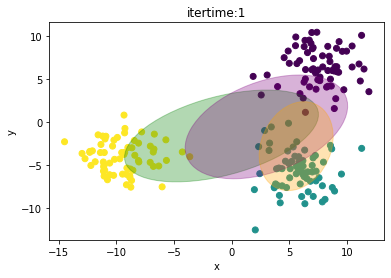

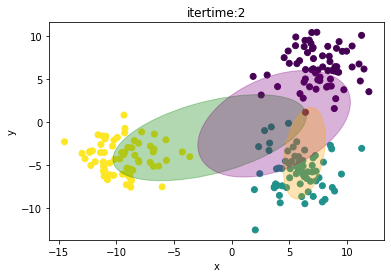

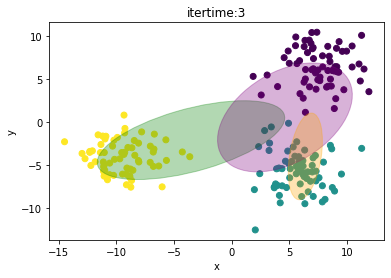

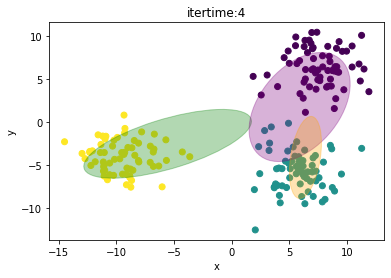

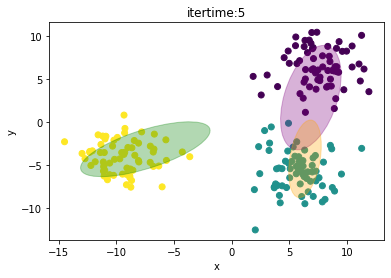

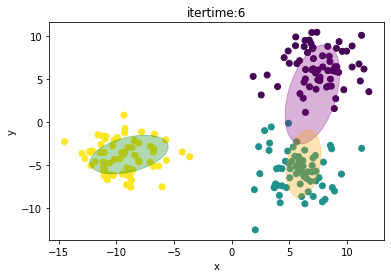

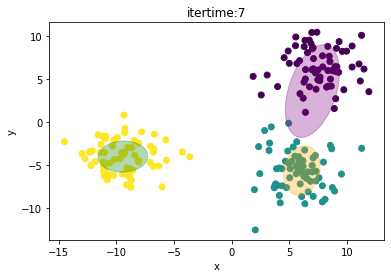

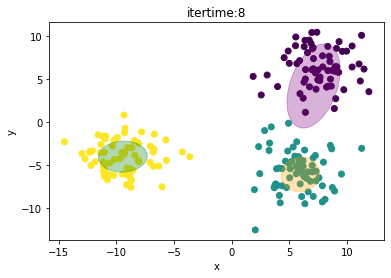

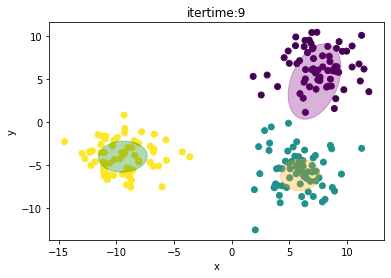

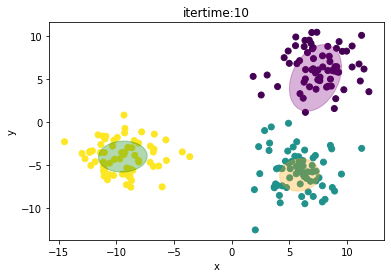

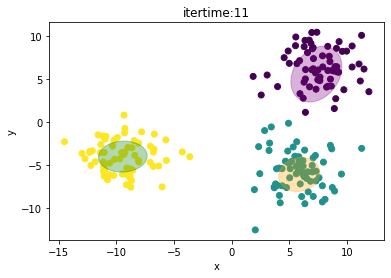

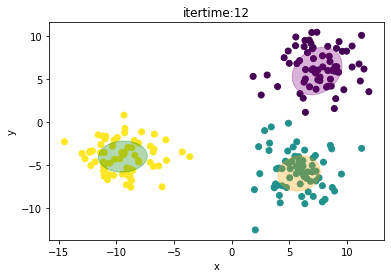

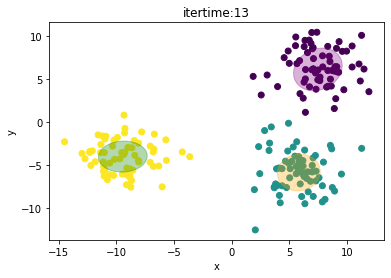

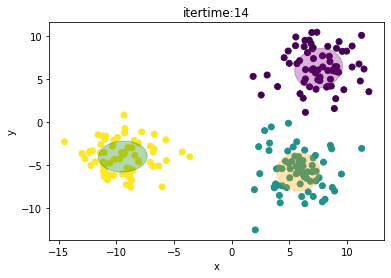

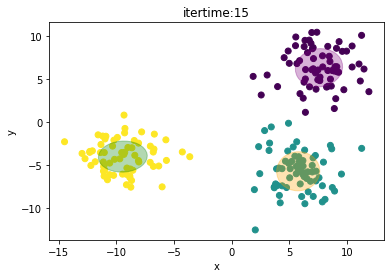

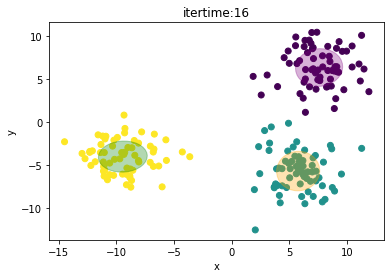

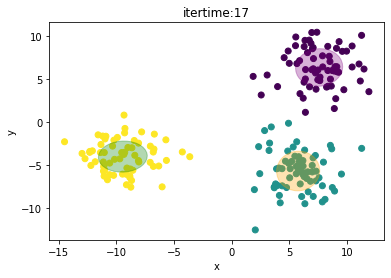

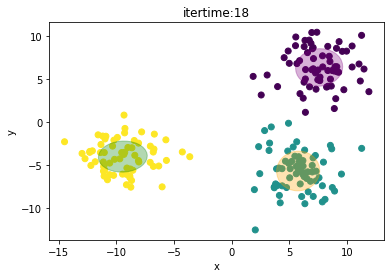

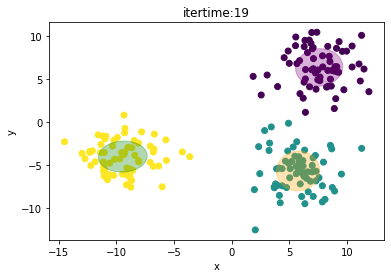

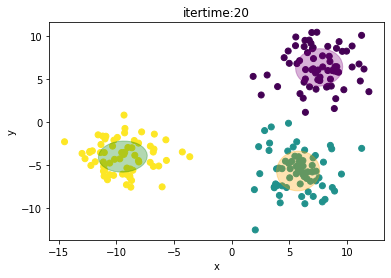

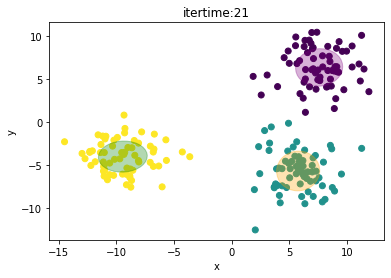

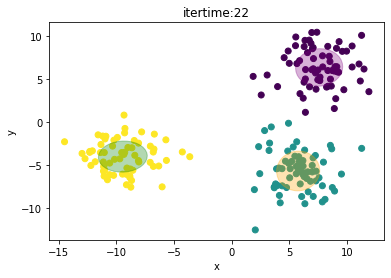

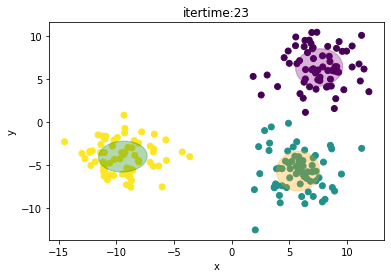

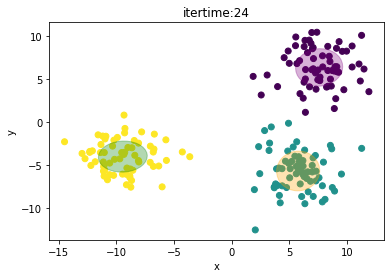

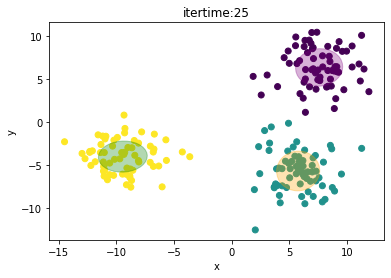

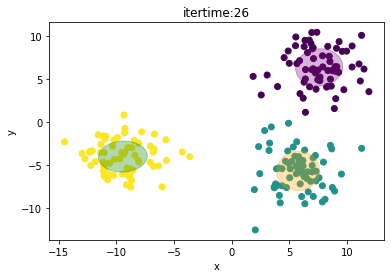

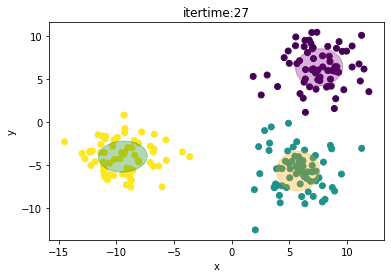

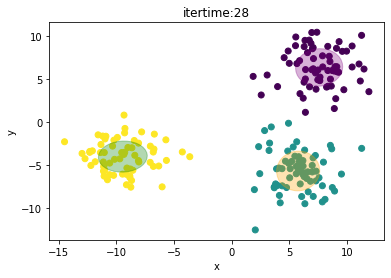

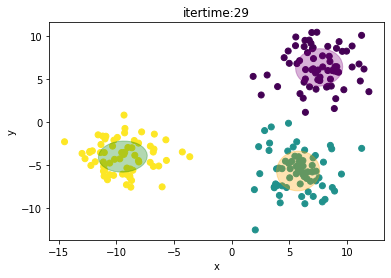

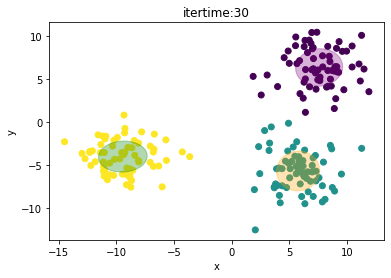

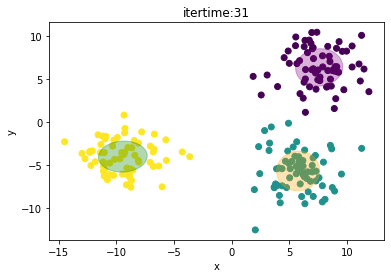

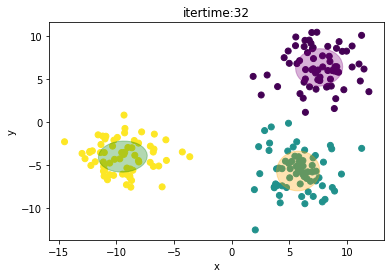

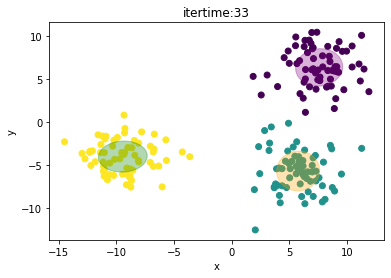

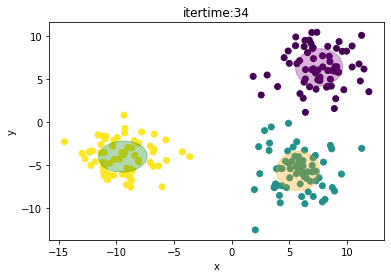

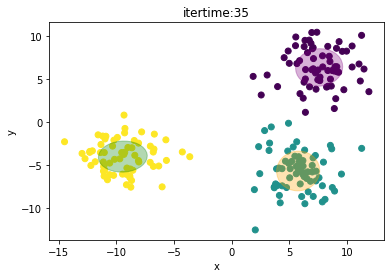

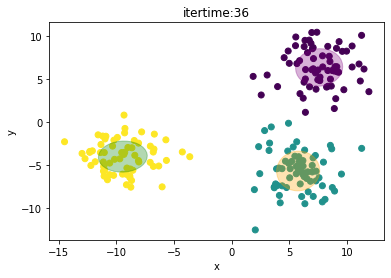

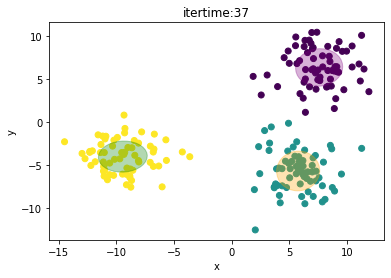

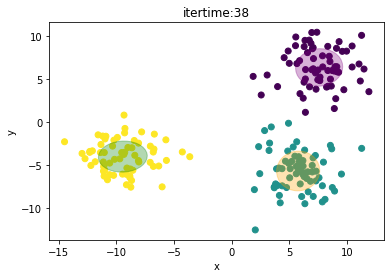

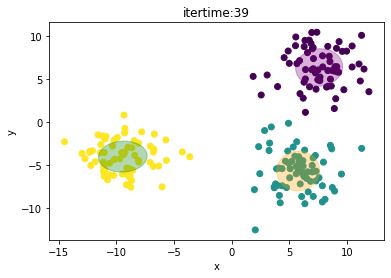

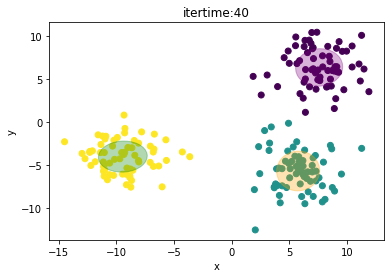

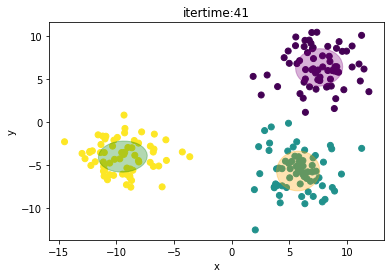

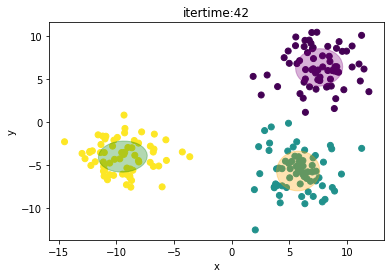

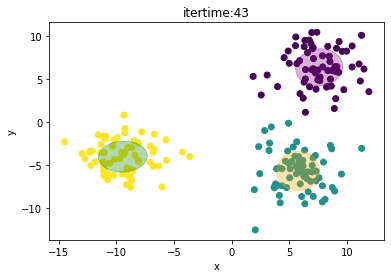

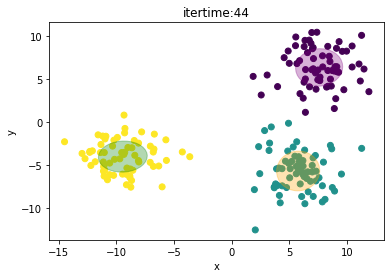

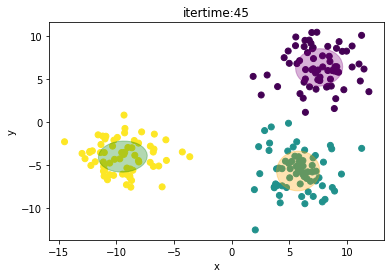

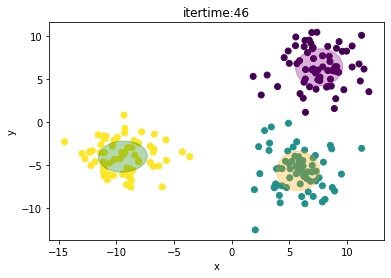

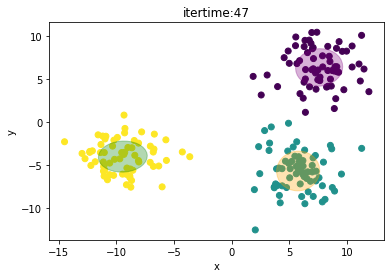

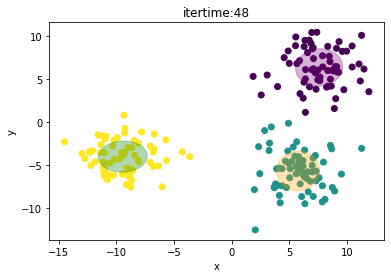

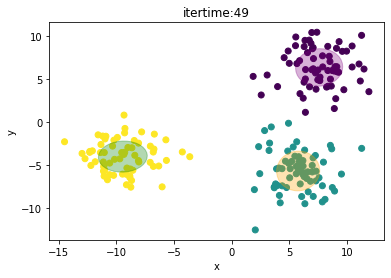

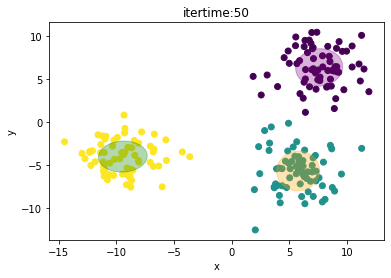

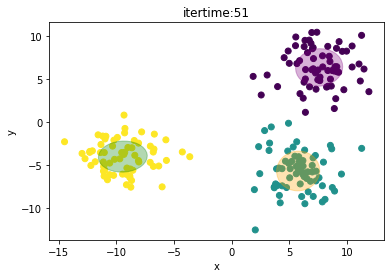

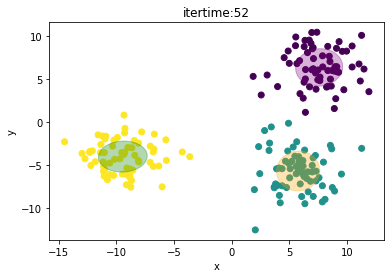

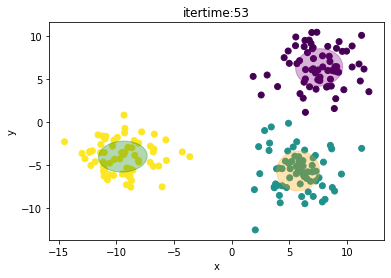

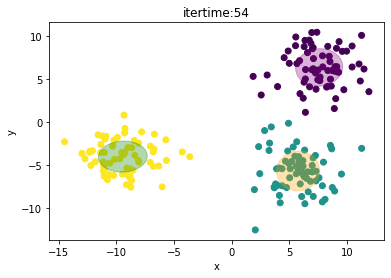

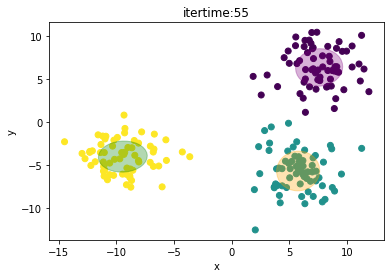

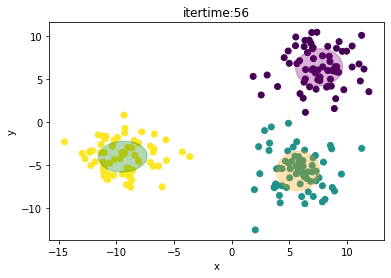

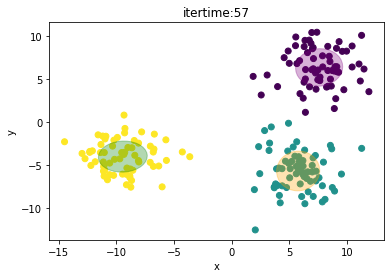

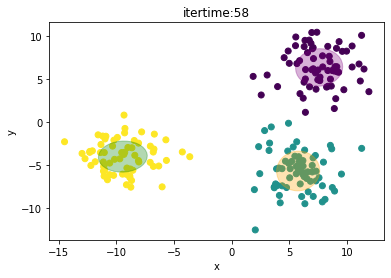

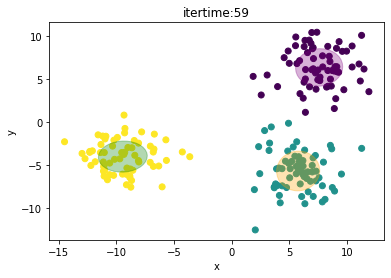

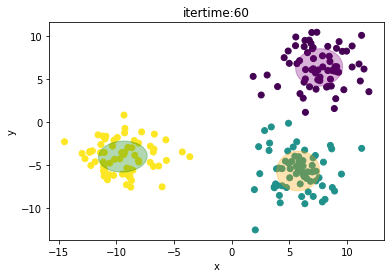

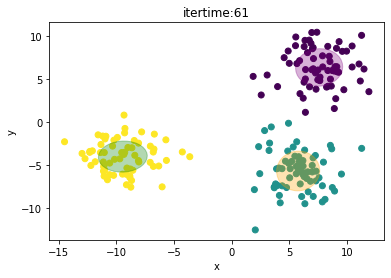

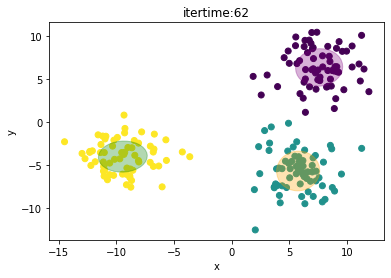

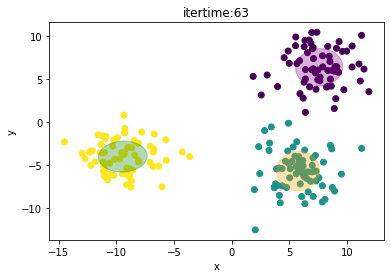

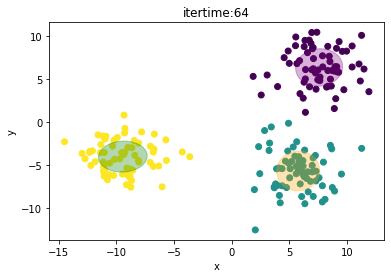

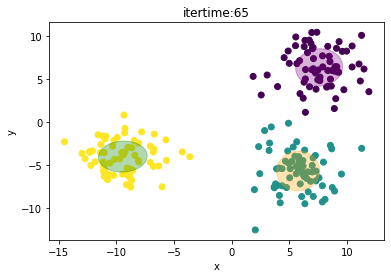

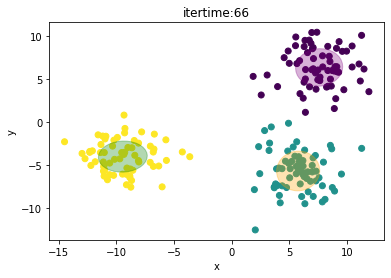

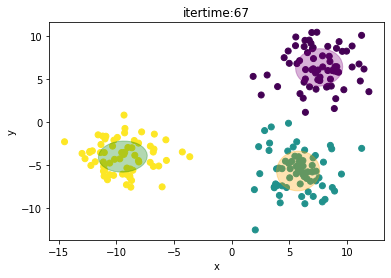

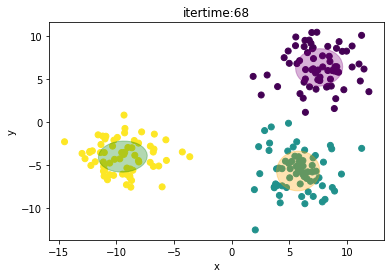

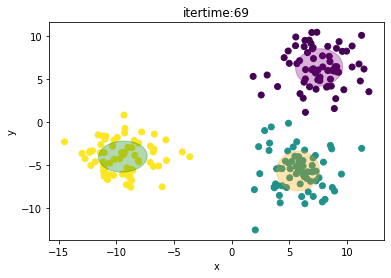

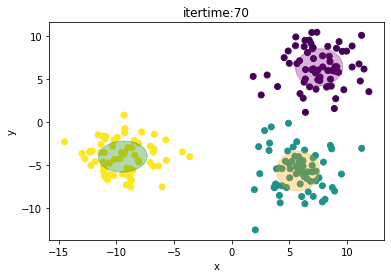

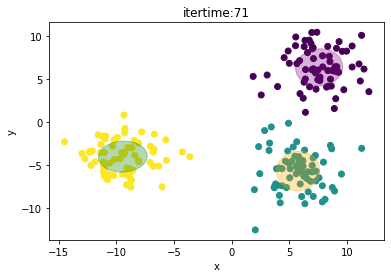

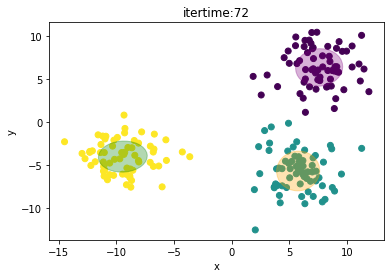

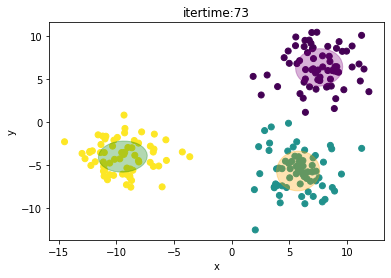

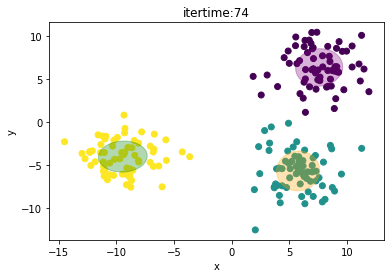

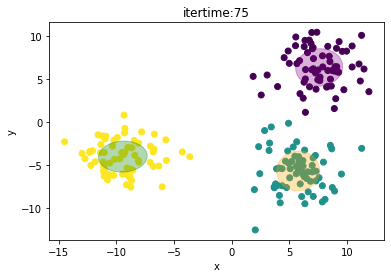

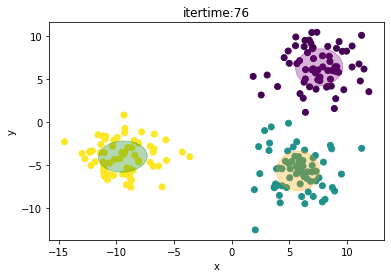

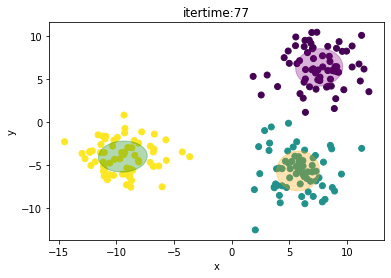

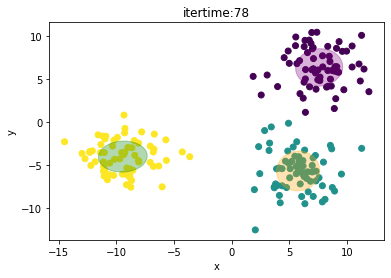

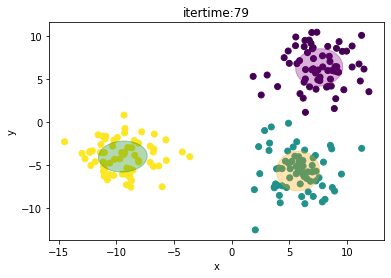

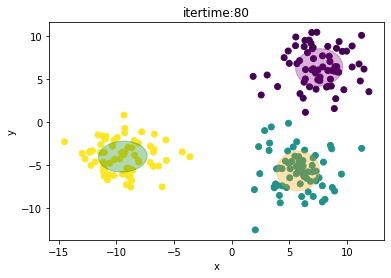

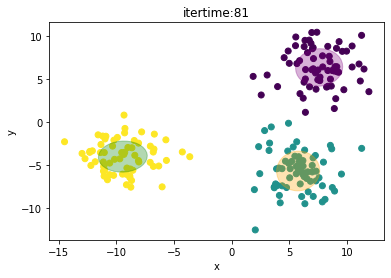

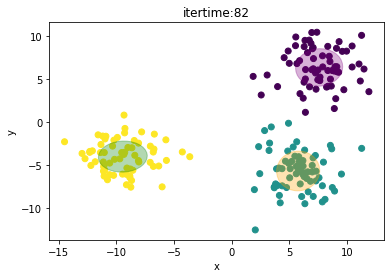

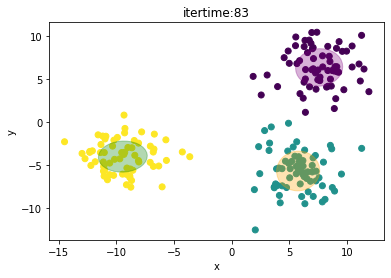

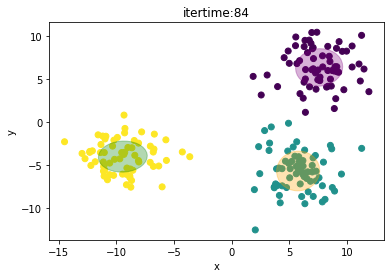

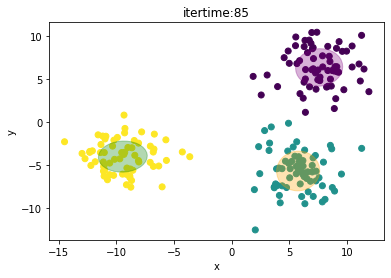

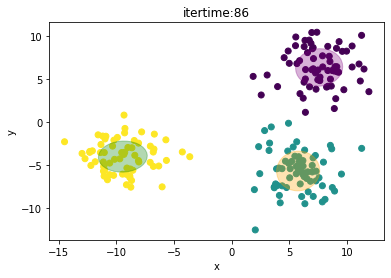

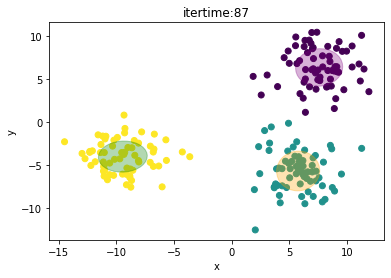

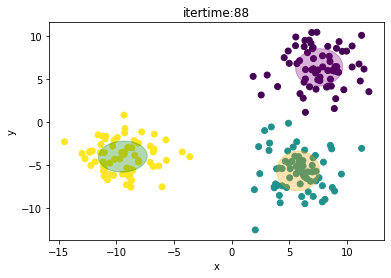

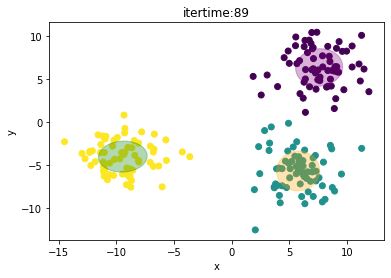

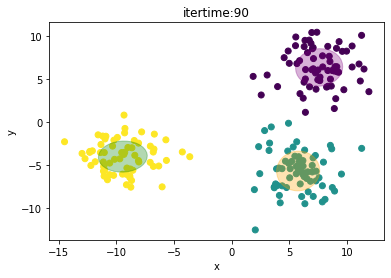

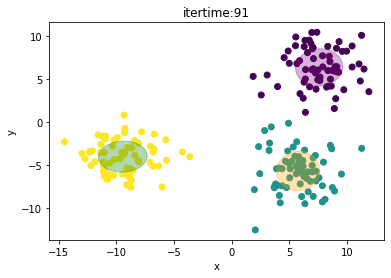

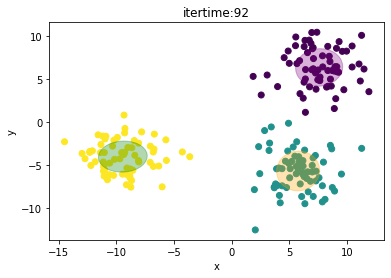

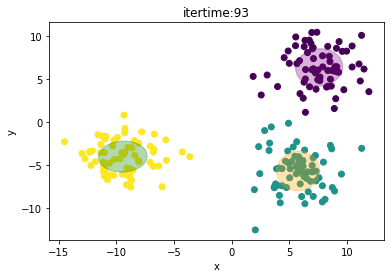

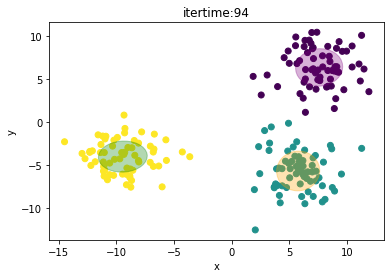

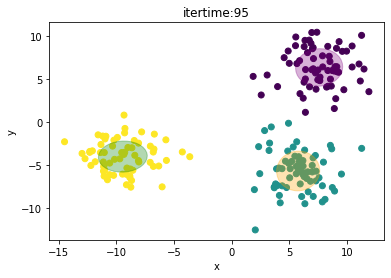

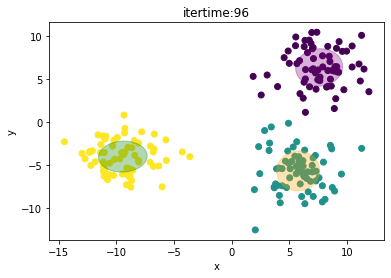

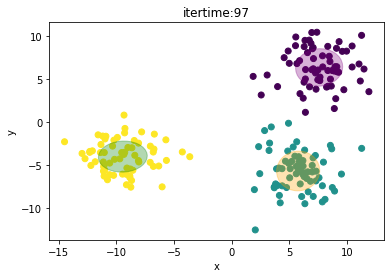

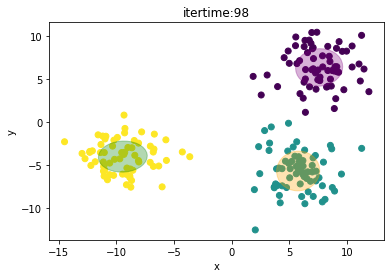

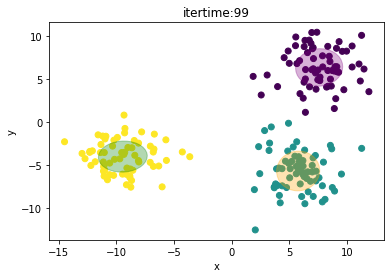

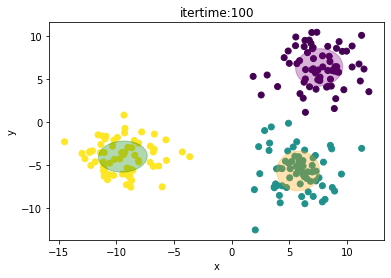

In [15]:
for i in range(100):
    p,means,covs=EM(data,p,means,covs)
    draw(data,label_GT,means,covs,i+1)